# **Import Library**

In [21]:
import cv2
import os
import random
from PIL import Image, ImageFile
import skimage
from skimage.transform import resize
from skimage.transform import rotate, warp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
import keras
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model

# **Upload Data dari Kaggle**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadzulzhafran","key":"5686cda5cf3ae2a4d173988f5d2bc804"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data

Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)
100% 479M/481M [00:01<00:00, 318MB/s]
100% 481M/481M [00:01<00:00, 420MB/s]


In [6]:
!unzip -q fracture-multi-region-x-ray-data.zip -d bone-fracture-dataset

# **Data Pre-processing**

In [7]:
TRAIN_DIR = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
VAL_DIR   = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'
TEST_DIR  = 'bone-fracture-dataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

## **Augmentasi & Generator**

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

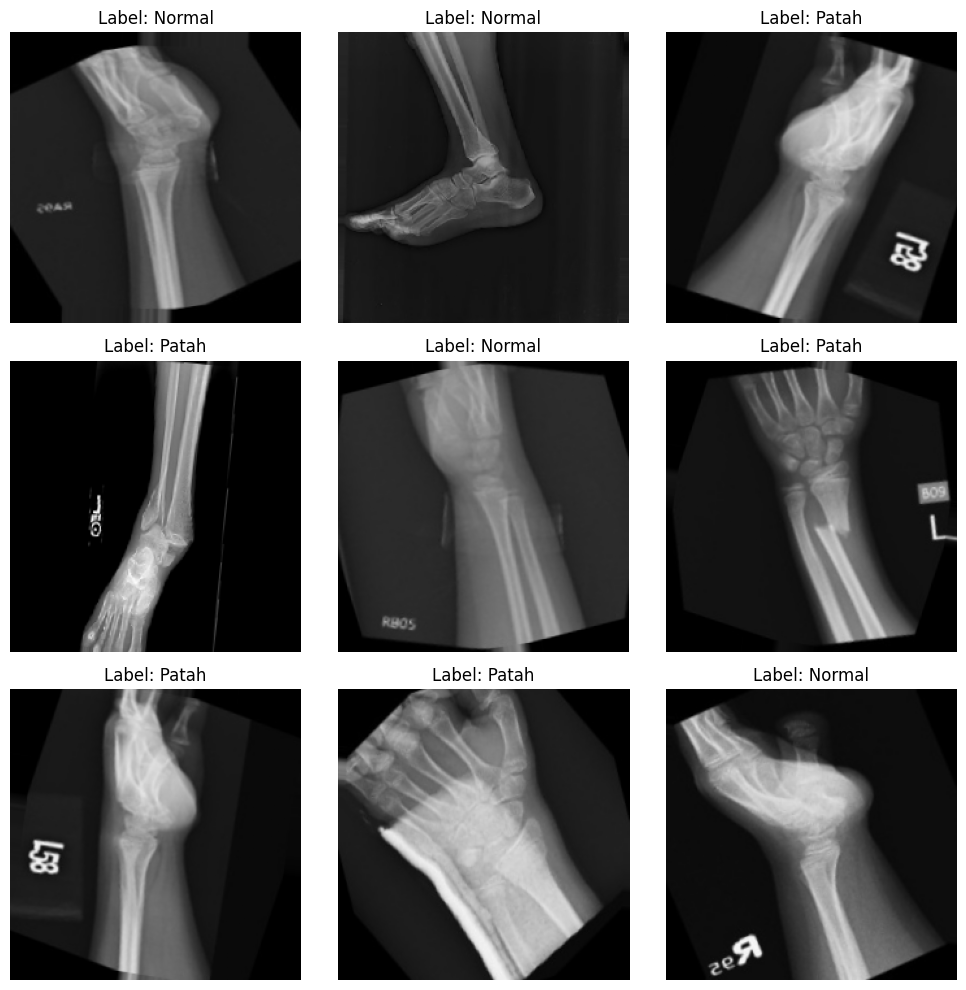

In [10]:
images, labels = next(train_generator)

# Tampilkan 9 sample data yang telah di-augmentasi
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i]), cmap='gray')

    label_text = 'Normal' if int(labels[i]) == 1 else 'Patah'
    plt.title(f"Label: {label_text}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Modelling**

## **Model Arsitektur VGG**

In [11]:
tf.keras.backend.clear_session()

# Load VGG16 model tanpa classifier (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Menambahkan custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Membuat model dengan VGG16 sebagai base
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           51

 Total params: 27,823,425 (106.14 MB)

 Trainable params: 13,108,737 (50.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## **Training Model**

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6617 - loss: 0.6212

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 176s 556ms/step - accuracy: 0.6621 - loss: 0.6207 - val_accuracy: 0.8963 - val_loss: 0.2684
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 132s 457ms/step - accuracy: 0.8919 - loss: 0.2736 - val_accuracy: 0.9059 - val_loss: 0.1832
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 145s 468ms/step - accuracy: 0.9545 - loss: 0.1342 - val_accuracy: 0.9397 - val_loss: 0.1331
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 137s 473ms/step - accuracy: 0.9775 - loss: 0.0789 - val_accuracy: 0.9505 - val_loss: 0.1038
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 136s 472ms/step - accuracy: 0.9817 - loss: 0.0588 - val_accuracy: 0.9602 - val_loss: 0.0927
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 136s 469ms/step - accuracy: 0.9879 - loss: 0.0388 - val_accuracy: 0.9578 - val_loss: 0.0785
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 135s 467ms/step - accuracy: 0.9910 - loss: 0.0301 - val_accuracy: 0.9566 - val_loss: 0.1086
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 140s 482ms/step - accuracy: 0.9844 - loss: 0.04

# **Plot Akurasi dan Loss Model**

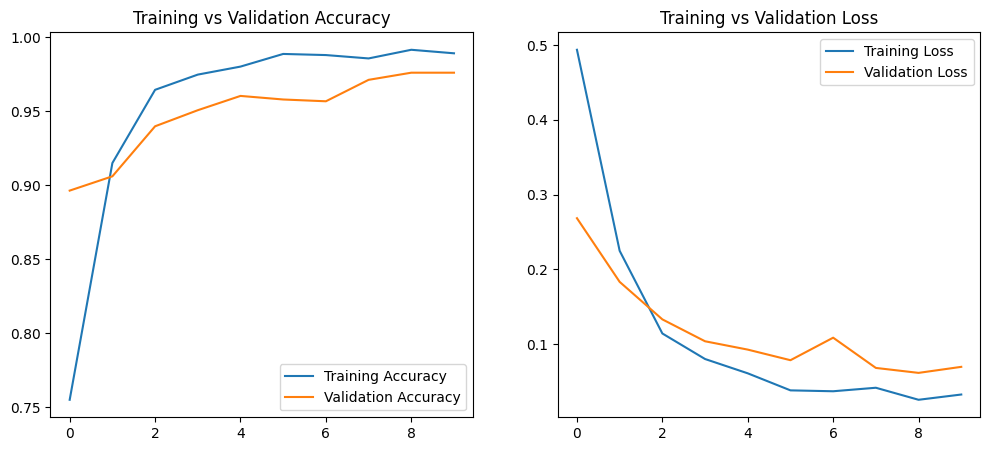

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


In [14]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Training Terakhir: {final_train_acc:.2%}")
print(f"Akurasi Validation Terakhir: {final_val_acc:.2%}")

Akurasi Training Terakhir: 98.90%
Akurasi Validation Terakhir: 97.59%


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step
Classification Report:
               precision    recall  f1-score   support

    fractured       0.98      1.00      0.99       238
not fractured       1.00      0.98      0.99       268

     accuracy                           0.99       506
    macro avg       0.99      0.99      0.99       506
 weighted avg       0.99      0.99      0.99       506



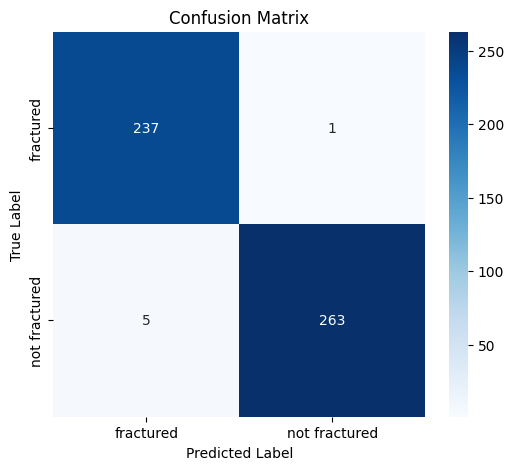

In [18]:
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 645ms/step - accuracy: 0.9928 - loss: 0.0317
Test Loss: 0.0437
Test Accuracy: 0.9881


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


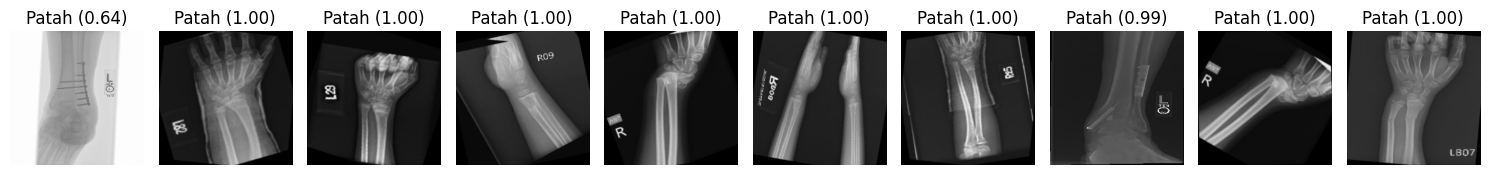

In [35]:
test_path = os.path.join(TEST_DIR, 'fractured')
all_images = os.listdir(test_path)

# Ambil 5 gambar acak
sample_images = random.sample(all_images, 10)

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(test_path, img_name)

    # Load gambar berwarna (RGB)
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    pred = model.predict(img_array)
    label_map = {0: 'Patah', 1: 'Normal'}
    pred_class = int(pred[0][0] > 0.5)
    label = label_map[pred_class]
    confidence = pred[0][0] if pred[0][0] > 0.5 else 1 - pred[0][0]

    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.title(f'{label} ({confidence:.2f})')
    plt.axis('off')

plt.tight_layout()
plt.show()